# Import necessary packages

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Activation
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import tensorflow_hub as hub

In [2]:
#transfer learning with tensorflow part 1: feature extraction

In [3]:
!nvidia-smi

Wed Dec 29 22:40:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#Download become familiar wit data

import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2021-12-29 22:40:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   177MB/s    in 0.9s    

2021-12-29 22:40:09 (177 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
import os
class_names = sorted(os.listdir("10_food_classes_10_percent"))

In [6]:
class_names

['test', 'train']

## Create datalaoder

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir ="10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size=BATCH_SIZE,
                                             target_size=IMAGE_SHAPE,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [8]:
#setting app callbacks

In [9]:
import datetime

def create_tensorboad_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to:{log_dir}")
  return tensorboard_callback

In [13]:
create_tensorboad_callback("kfsjdkfjdksf","gkjdkjgkf")
IMAGE_SHAPE + (3,)

Saving TensorBoard log files to:kfsjdkfjdksf/gkjdkjgkf/20211229-224100


(224, 224, 3)

## Create model using tensorflow hub

In [11]:
efficeientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [42]:
def create_model(model_url,num_classes=10):


  feature_extractor = hub.KerasLayer(model_url,
                                     trainable=False,
                                     name="feature_extraction_layer",
                                     input_shape=IMAGE_SHAPE + (3,)) # Freeze all learned patterns
  

  model = Sequential([
    feature_extractor,
    Dense(num_classes,activation="softmax",name="output_layer")
              
  ])
  return model

In [53]:
#create resnet model
resnet_model = create_model(resnet_url)

In [54]:
resnet_model.compile(loss=CategoricalCrossentropy(),
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [55]:
history = resnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboad_callback("tensorflow_hub",
                                                       "resnet50v2")])

Saving TensorBoard log files to:tensorflow_hub/resnet50v2/20211229-233747
Epoch 1/5
24/24 [==============================] - 17s 586ms/step - loss: 2.0749 - accuracy: 0.3093 - val_loss: 1.2784 - val_accuracy: 0.5972
Epoch 2/5
24/24 [==============================] - 13s 562ms/step - loss: 0.9649 - accuracy: 0.7053 - val_loss: 0.8792 - val_accuracy: 0.7240
Epoch 3/5
24/24 [==============================] - 13s 558ms/step - loss: 0.6474 - accuracy: 0.8120 - val_loss: 0.7602 - val_accuracy: 0.7564
Epoch 4/5
24/24 [==============================] - 14s 592ms/step - loss: 0.4905 - accuracy: 0.8627 - val_loss: 0.7065 - val_accuracy: 0.7716
Epoch 5/5
24/24 [==============================] - 13s 562ms/step - loss: 0.3930 - accuracy: 0.9053 - val_loss: 0.6714 - val_accuracy: 0.7836


In [44]:
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [52]:
# create a function to plot a loss curve

In [60]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss

  plt.plot(epochs,loss,label="Training loss")
  plt.plot(epochs,val_loss,label="Validation loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot accuracy

  plt.figure()
  plt.plot(epochs,accuracy,label="Training accuracy")
  plt.plot(epochs,val_accuracy,label="Validation Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend() 

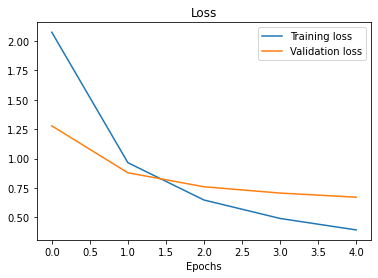

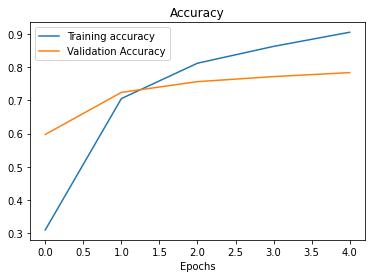

In [61]:
plot_loss_curves(history)

## Creating efficient net model(Transfer learning)



In [63]:
eff_model = create_model(efficeientnet_url)

In [64]:
eff_model.compile(loss=CategoricalCrossentropy(),
                  optimizer=Adam(),
                  metrics=["accuracy"])

In [66]:
hist_2 = eff_model.fit(train_data,
              epochs=5,
              validation_data=test_data,
              validation_steps=len(test_data),
              steps_per_epoch=len(train_data),
              callbacks=[create_tensorboad_callback("tensorflow_hub","efficientnet")])

Saving TensorBoard log files to:tensorflow_hub/efficientnet/20211229-234740
Epoch 1/5
24/24 [==============================] - 24s 654ms/step - loss: 1.8126 - accuracy: 0.4680 - val_loss: 1.2895 - val_accuracy: 0.7176
Epoch 2/5
24/24 [==============================] - 14s 599ms/step - loss: 1.0455 - accuracy: 0.7893 - val_loss: 0.8627 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 14s 595ms/step - loss: 0.7504 - accuracy: 0.8253 - val_loss: 0.6911 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 13s 577ms/step - loss: 0.6016 - accuracy: 0.8667 - val_loss: 0.6057 - val_accuracy: 0.8564
Epoch 5/5
24/24 [==============================] - 13s 565ms/step - loss: 0.5044 - accuracy: 0.8933 - val_loss: 0.5515 - val_accuracy: 0.8640


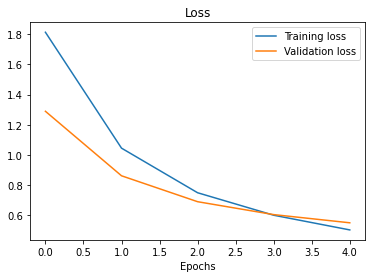

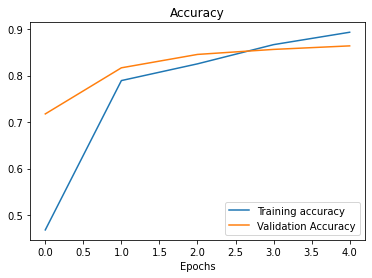

In [67]:
plot_loss_curves(hist_2)

In [68]:
# Using Tensorboard

In [72]:
! tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs Resnet50" --description "Comparing Two different feature extraction model architectures" --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=lZXIltgUBGPEB4WGmHccdPoLns4Yd7&prompt=consent&access_type=off

Tensorboard link: https://tensorboard.dev/experiment/3FykoCa6QEec7pyJu2504Q/